<a href="https://colab.research.google.com/github/Uzmamushtaque/Projects-in-Machine-Learning-and-AI/blob/main/Youtube.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Youtube Video predictions

Using this youtube dataset, we want to answer the following research questions:

1. Predict the number of views for a given channel(user) for their next video.
2. Recommend titles/hashtags to channels(users) to get higher views.

In [1]:
! pip install kaggle

In [2]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [3]:
! cp kaggle.json ~/.kaggle/

In [4]:
! chmod 600 ~/.kaggle/kaggle.json

In [4]:
! kaggle datasets download datasnaek/youtube-new

 99% 199M/201M [00:02<00:00, 106MB/s] 
100% 201M/201M [00:02<00:00, 88.4MB/s]


In [7]:
! unzip youtube-new.zip

Archive:  youtube-new.zip
  inflating: CA_category_id.json     
  inflating: CAvideos.csv            
  inflating: DE_category_id.json     
  inflating: DEvideos.csv            
  inflating: FR_category_id.json     
  inflating: FRvideos.csv            
  inflating: GB_category_id.json     
  inflating: GBvideos.csv            
  inflating: IN_category_id.json     
  inflating: INvideos.csv            
  inflating: JP_category_id.json     
  inflating: JPvideos.csv            
  inflating: KR_category_id.json     
  inflating: KRvideos.csv            
  inflating: MX_category_id.json     
  inflating: MXvideos.csv            
  inflating: RU_category_id.json     
  inflating: RUvideos.csv            
  inflating: US_category_id.json     
  inflating: USvideos.csv            


In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
import datetime
import wordcloud
import json


import warnings
warnings.filterwarnings("ignore")

In [9]:
df = pd.read_csv("USvideos.csv")

In [9]:
df.head()

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
0,2kyS6SvSYSE,17.14.11,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13T17:13:01.000Z,SHANtell martin,748374,57527,2966,15954,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...
1,1ZAPwfrtAFY,17.14.11,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,24,2017-11-13T07:30:00.000Z,"last week tonight trump presidency|""last week ...",2418783,97185,6146,12703,https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg,False,False,False,"One year after the presidential election, John..."
2,5qpjK5DgCt4,17.14.11,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,2017-11-12T19:05:24.000Z,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146033,5339,8181,https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg,False,False,False,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...
3,puqaWrEC7tY,17.14.11,Nickelback Lyrics: Real or Fake?,Good Mythical Morning,24,2017-11-13T11:00:04.000Z,"rhett and link|""gmm""|""good mythical morning""|""...",343168,10172,666,2146,https://i.ytimg.com/vi/puqaWrEC7tY/default.jpg,False,False,False,Today we find out if Link is a Nickelback amat...
4,d380meD0W0M,17.14.11,I Dare You: GOING BALD!?,nigahiga,24,2017-11-12T18:01:41.000Z,"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...",2095731,132235,1989,17518,https://i.ytimg.com/vi/d380meD0W0M/default.jpg,False,False,False,I know it's been a while since we did this sho...


In [10]:
df.describe()

,category_id,views,likes,dislikes,comment_count
count,40949.000000,4.094900e+04,4.094900e+04,4.094900e+04,4.094900e+04
mean,19.972429,2.360785e+06,7.426670e+04,3.711401e+03,8.446804e+03
std,7.568327,7.394114e+06,2.288853e+05,2.902971e+04,3.743049e+04
min,1.000000,5.490000e+02,0.000000e+00,0.000000e+00,0.000000e+00
25%,17.000000,2.423290e+05,5.424000e+03,2.020000e+02,6.140000e+02
50%,24.000000,6.818610e+05,1.809100e+04,6.310000e+02,1.856000e+03
75%,25.000000,1.823157e+06,5.541700e+04,1.938000e+03,5.755000e+03
max,43.000000,2.252119e+08,5.613827e+06,1.674420e+06,1.361580e+06


In [11]:
len(df.channel_title.unique())

2207

In [12]:
df.groupby(['channel_title']).sum()

,category_id,views,likes,dislikes,comment_count,comments_disabled,ratings_disabled,video_error_or_removed
channel_title,,,,,,,,
12 News,44,177970,352,90,0,0,0,0
1MILLION Dance Studio,792,20959169,1399898,15030,110408,0,0,0
1theK (원더케이),190,57375949,3663362,63329,255669,0,0,0
20th Century Fox,135,1082872611,24419452,488761,1509224,0,0,0
2CELLOS,20,432186,22900,245,917,0,0,0
...,...,...,...,...,...,...,...,...
ワーナー ブラザース 公式チャンネル,6,7389323,154962,6128,21560,0,0,0
圧倒的不審者の極み!,336,11417717,157447,12315,54177,0,0,0
杰威爾音樂 JVR Music,290,400530463,3400678,229439,382766,0,0,0


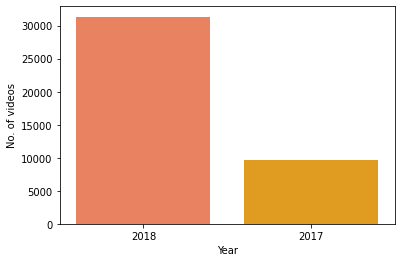

In [13]:
cdf = df["trending_date"].apply(lambda x: '20' + x[:2]).value_counts() \
            .to_frame().reset_index() \
            .rename(columns={"index": "year", "trending_date": "No_of_videos"})

fig, ax = plt.subplots()
_ = sns.barplot(x="year", y="No_of_videos", data=cdf, 
                palette=sns.color_palette(['#ff764a', '#ffa600'], n_colors=7), ax=ax)
_ = ax.set(xlabel="Year", ylabel="No. of videos")

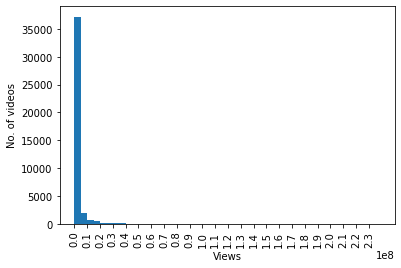

In [14]:
fig, ax = plt.subplots()
_ = sns.distplot(df["views"], kde=False, 
                 hist_kws={'alpha': 1}, bins=np.linspace(0, 2.3e8, 47), ax=ax)
_ = ax.set(xlabel="Views", ylabel="No. of videos", xticks=np.arange(0, 2.4e8, 1e7))
_ = ax.set_xlim(right=2.5e8)
_ = plt.xticks(rotation=90)

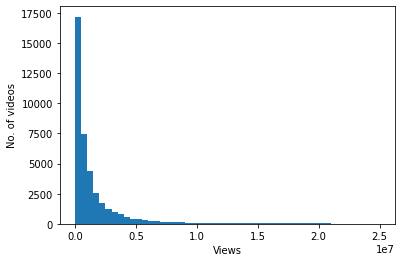

In [15]:
fig,ax=plt.subplots()
_=sns.distplot(df[df['views']<25e6]['views'],kde=False,hist_kws={'alpha': 1},ax=ax)
_=ax.set(xlabel='Views',ylabel='No. of videos')

In [16]:
df[df['views']<1e6]['views'].count()/df['views'].count()*100

60.09426359618062

In [17]:
df.describe(include = ['O'])

,video_id,trending_date,title,channel_title,publish_time,tags,thumbnail_link,description
count,40949,40949,40949,40949,40949,40949,40949,40379
unique,6351,205,6455,2207,6269,6055,6352,6901
top,j4KvrAUjn6c,18.16.02,WE MADE OUR MOM CRY...HER DREAM CAME TRUE!,ESPN,2018-05-18T14:00:04.000Z,[none],https://i.ytimg.com/vi/j4KvrAUjn6c/default.jpg,► Listen LIVE: http://power1051fm.com/\n► Face...
freq,30,200,30,203,50,1535,30,58


In [29]:
#which channel has the maximum views

df_new=df.groupby(['channel_title']).sum('views')
df_new.sort_values(by=['views'],ascending=False)

,category_id,views,likes,dislikes,comment_count,comments_disabled,ratings_disabled,video_error_or_removed
channel_title,,,,,,,,
ChildishGambinoVEVO,250,3758488765,96700818,6054434,10151289,0,0,0
ibighit,800,2235906679,199247121,3467306,31817464,0,0,0
Dude Perfect,2227,1870085178,60275557,1501477,4009163,0,0,0
Marvel Entertainment,2824,1808998971,55873344,1031250,6453560,0,0,0
ArianaGrandeVevo,430,1576959172,52170970,1931230,4295333,0,0,0
...,...,...,...,...,...,...,...,...
CHauserable,23,1807,6,3,0,0,0,0
Total Combat,17,1722,17,3,1,0,0,0
OjO Commuter Scooter by OjO Electric,38,1706,6,1,0,0,0,0


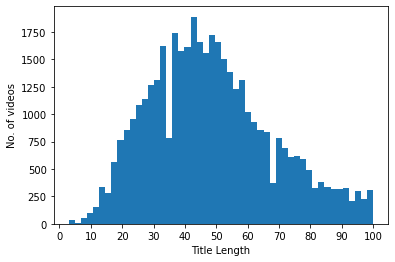

In [31]:
#Video title lengths

df["title_length"] = df["title"].apply(lambda x: len(x))

fig, ax = plt.subplots()
_ = sns.distplot(df["title_length"], kde=False, rug=False, 
                  hist_kws={'alpha': 1}, ax=ax)
_ = ax.set(xlabel="Title Length", ylabel="No. of videos", xticks=range(0, 110, 10))

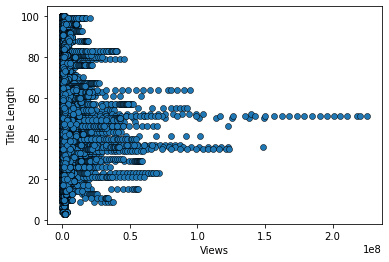

In [33]:
#let's draw a scatter plot between title length and number of views to see the relationship between these two variables

fig, ax = plt.subplots()
_ = ax.scatter(x=df['views'], y=df['title_length'], edgecolors="#000000", linewidths=0.5)
_ = ax.set(xlabel="Views", ylabel="Title Length")

In [34]:
df.corr()

,category_id,views,likes,dislikes,comment_count,comments_disabled,ratings_disabled,video_error_or_removed,title_length
category_id,1.000000,-0.168231,-0.173921,-0.033547,-0.076307,0.048949,-0.013506,-0.030011,0.024199
views,-0.168231,1.000000,0.849177,0.472213,0.617621,0.002677,0.015355,-0.002256,-0.035612
likes,-0.173921,0.849177,1.000000,0.447186,0.803057,-0.028918,-0.020888,-0.002641,-0.078166
dislikes,-0.033547,0.472213,0.447186,1.000000,0.700184,-0.004431,-0.008230,-0.001853,-0.031235
comment_count,-0.076307,0.617621,0.803057,0.700184,1.000000,-0.028277,-0.013819,-0.003725,-0.067043
comments_disabled,0.048949,0.002677,-0.028918,-0.004431,-0.028277,1.000000,0.319230,-0.002970,0.026668
ratings_disabled,-0.013506,0.015355,-0.020888,-0.008230,-0.013819,0.319230,1.000000,-0.001526,0.001442
video_error_or_removed,-0.030011,-0.002256,-0.002641,-0.001853,-0.003725,-0.002970,-0.001526,1.000000,-0.013833
title_length,0.024199,-0.035612,-0.078166,-0.031235,-0.067043,0.026668,0.001442,-0.013833,1.000000


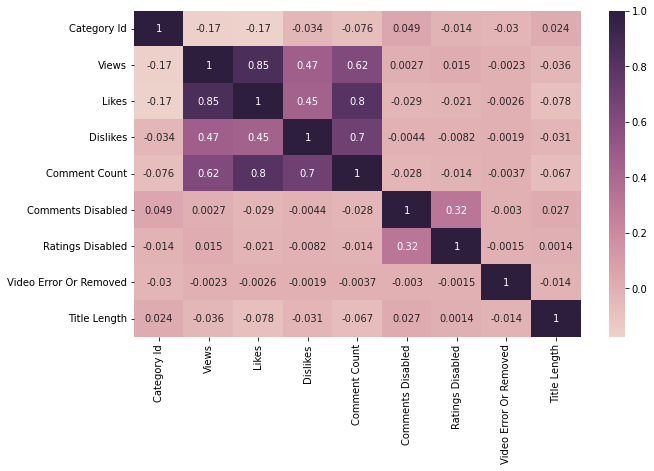

In [35]:
h_labels = [x.replace('_', ' ').title() for x in 
            list(df.select_dtypes(include=['number', 'bool']).columns.values)]

fig, ax = plt.subplots(figsize=(10,6))
_ = sns.heatmap(df.corr(), annot=True, xticklabels=h_labels, yticklabels=h_labels, 
                cmap=sns.cubehelix_palette(as_cmap=True), ax=ax)

In [38]:
title_words = list(df["title"].apply(lambda x: x.split()))
title_words = [x for y in title_words for x in y]
Counter(title_words).most_common(25)

[('-', 11452),
 ('|', 10663),
 ('The', 5762),
 ('the', 3610),
 ('a', 2566),
 ('to', 2343),
 ('of', 2338),
 ('in', 2176),
 ('A', 2122),
 ('&', 2024),
 ('I', 1940),
 ('and', 1917),
 ('Video)', 1901),
 ('Trailer', 1868),
 ('How', 1661),
 ('with', 1655),
 ('2018', 1613),
 ('(Official', 1594),
 ('Official', 1554),
 ('on', 1552),
 ('To', 1397),
 ('You', 1254),
 ('My', 1080),
 ('for', 1020),
 ('ft.', 1017)]

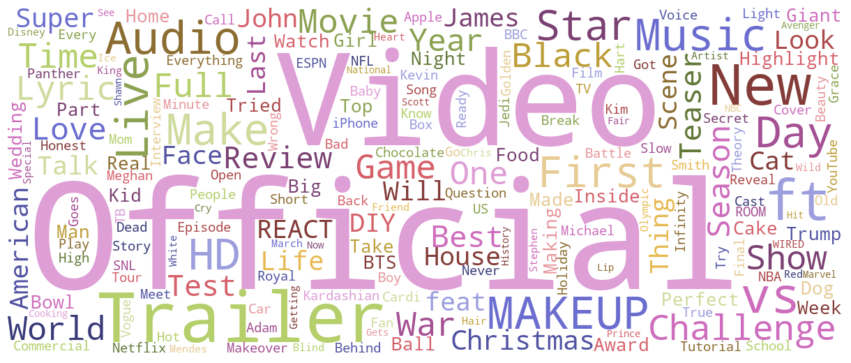

In [39]:
wc = wordcloud.WordCloud(width=1200, height=500, 
                         collocations=False, background_color="white", 
                         colormap="tab20b").generate(" ".join(title_words))
plt.figure(figsize=(15,10))
plt.imshow(wc, interpolation='bilinear')
_ = plt.axis("off")

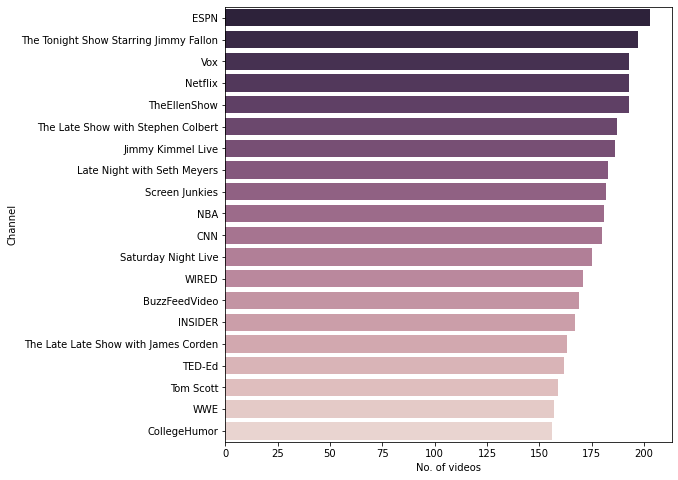

In [40]:
#Which channel has the most number of trending videos
cdf = df.groupby("channel_title").size().reset_index(name="video_count") \
    .sort_values("video_count", ascending=False).head(20)

fig, ax = plt.subplots(figsize=(8,8))
_ = sns.barplot(x="video_count", y="channel_title", data=cdf,
                palette=sns.cubehelix_palette(n_colors=20, reverse=True), ax=ax)
_ = ax.set(xlabel="No. of videos", ylabel="Channel")